### 前馈神经网络
把多个仿射层级联起来, 形成神经网络
![FFNN.jpg](FFNN.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
path = os.getcwd()
os.chdir('..')
from deepnotes import *
os.chdir(path)
%matplotlib inline

### Adam
SGD优化器比较简单高效，而Adam优化器在非凸优化中的表现比较良好。它使用两个动量因子实现一阶点估计和二阶矩估计，使用矩估计的开方作为分母来实现自适应学习率，是一种结合了momentum方法和RMSProp两种优化器优点的方法。

### 激活函数
只有线性层的网络, 其本质就是多个矩阵相乘, 化简后得到的仍然是矩阵, 无法得到非线性. 为了让网络有非线性的能力, 我们会在线性层之前穿插激活函数.也就是整个神经网络的输出写做
$$ o = (...acti((acti(xW_1+b_1))W_2+b_2)...)W_n+b_n $$
激活函数接收m维向量, 在向量的每个元素上做非线性变换. 输出m维向量. 逻辑回归时我们用到了sigmoid这种函数, 它可以作为一种激活函数, 但它不是最好的函数. sigmoid虽然求导简单但是存在一些问题, 因为它的前向传播和反向传播计算导数的公式是
$$ f(v)=\frac {1} {1+e^{(-v)}}$$
$$ f^{'}(v)=f(v)(1-f(v)) $$
可以看见, 部分导是恒小于1的. 如果用这种激活函数就会在较为深层的网络(比如ResNet会有十几层的卷积层和线性层)中出现梯度的快速衰减, 以至于上层的线性层参数得不到有效更新, 进而无法有效训练网络. 在ResNet中我们会用一些技巧防止这个现象出现, 其中包括使用特殊的激活函数ReLU, 线性整流函数. 
$$ ReLU(v) = v\ if\ v>0\ else\ 0 $$ 
$$ ReLU'(v) = 1\ if\ v>0\ else\ 0 $$ 
在RNN中, 我们会用tanh这个函数代替sigmoid, 从而让梯度不衰减得太厉害.  
$$ tanh(v) = \frac{e^x-e^{-x}}{e^x+e^{-x}} $$
$$ tanh'(v) = 1-(tanh(v))^2 $$

In [2]:
import tensorflow as tf

# load mnist dataset
(x_train_origin,t_train_origin),(x_test_origin,t_test_origin) = tf.keras.datasets.mnist.load_data()

# batch data loader
X_train,X_test = x_train_origin/255.,x_test_origin/255.
batch_size = 100

train_loader = DataLoader(X_train,t_train_origin,batch_size)
test_loader = DataLoader(X_test,t_test_origin,batch_size)

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Epoch [1/5], Step [100/600], Loss: 0.5787
Epoch [1/5], Step [200/600], Loss: 0.2822
Epoch [1/5], Step [300/600], Loss: 0.2136
Epoch [1/5], Step [400/600], Loss: 0.1944
Epoch [1/5], Step [500/600], Loss: 0.1840
Epoch [1/5], Step [600/600], Loss: 0.1331
Epoch [2/5], Step [100/600], Loss: 0.1221
Epoch [2/5], Step [200/600], Loss: 0.1138
Epoch [2/5], Step [300/600], Loss: 0.1027
Epoch [2/5], Step [400/600], Loss: 0.1000
Epoch [2/5], Step [500/600], Loss: 0.1043
Epoch [2/5], Step [600/600], Loss: 0.0753
Epoch [3/5], Step [100/600], Loss: 0.0731
Epoch [3/5], Step [200/600], Loss: 0.0690
Epoch [3/5], Step [300/600], Loss: 0.0646
Epoch [3/5], Step [400/600], Loss: 0.0608
Epoch [3/5], Step [500/600], Loss: 0.0649
Epoch [3/5], Step [600/600], Loss: 0.0459
Epoch [4/5], Step [100/600], Loss: 0.0450
Epoch [4/5], Step [200/600], Loss: 0.0439
Epoch [4/5], Step [300/600], Loss: 0.0416
Epoch [4/5], Step [400/600], Loss: 0.0410
Epoch [4/5], Step [500/600], Loss: 0.0460
Epoch [4/5], Step [600/600], Loss:

Text(0.5,1,'Train loss(Cross Entropy)')

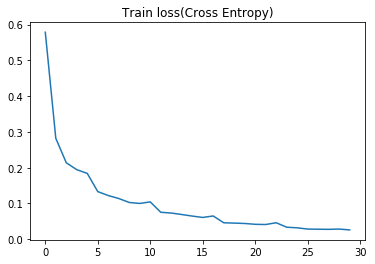

In [4]:
num_epochs = 5
total_step = len(train_loader)

model = Sequential(
    Linear(28*28,256),
    ReLU(),
    Linear(256,128),
    ReLU(),
    Linear(128,10)
)
loss_func = CrossEntropyLossWithSoftMax(10)
optimizer = Adam(0.001)
model.apply_optim(optimizer)

loss_list = []
log_step = 100 

for epoch in range(num_epochs):
    running_loss = 0.
    for i in range(total_step):
        x,y = train_loader.get_batch()
        x = x.reshape(x.shape[0],-1)
        # Forward pass
        logits = model(x)
        # calculate loss
        loss,dlogits = loss_func(logits,y)
        # Backward
        model.zero_grad()
        model.backward(dlogits)
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i+1) % log_step == 0:
            running_loss/=log_step
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss))
            loss_list.append(running_loss)
            running_loss = 0.

plt.plot(loss_list)
plt.title('Train loss(Cross Entropy)')

In [5]:
correct = 0
total = 0

for i in range(len(test_loader)):
    x,y = test_loader.get_batch()
    x = x.reshape(x.shape[0],-1)
    outputs = model(x)
    predicted = np.argmax(outputs, axis = 1)
    total += y.shape[0]
    correct += (predicted == y).sum()
    
print('Accuracy of the network on the 10000 test images: %.2f %%'%(100 * correct / total))

Accuracy of the network on the 10000 test images: 96.25 %


### 神经网络优化遇到的问题
**局部最优**  
我们一直避而不谈的一个问题是，为什么神经网络能用SGD train到全局最优？前面学习逻辑回归时，梯度下降能把loss优化到最优，是因为不论是MSE误差，还是BCE误差，它们在逻辑回归的模型上都是凸优化，所以我们必然能用梯度下降找到最优解。但神经网络不同，我们并不知道它是不是凸优化啊？  
事实上也和我们的直觉相同，神经网络不是凸优化，而且我们也很难去找到一个全局最优。一个相当反直觉的现实是，我们连局部最优都很难找到。优化理论告诉我们，一个函数上的某点如果是局部最优，那么它的Hessian矩阵是正定的。正定的矩阵要求所有矩阵特征值都是正的，而在一个大型网络里，对成千上万的参数所在的高维空间，计算出的H矩阵将会非常巨大，特征值也非常多。而想找到一个点让所有特征值都是正的极为困难，也就是，在参数空间内，我们几乎不可能触摸到局部最优，这也就让所谓被"局部最优"卡住，找不到全局最优的事情几乎不可能发生。  
**鞍点**   
换句话来说，我们训练神经网络时面对的问题并不是被局部最优限制，而是被一般的0梯度点，即鞍点限制。而幸运的是，鞍点并不具备局部最小点的那种强大的吸引力，在随机梯度下降和随机初始化下生成的网络，虽然会经过鞍点，但在连续的梯度下降优化下，都会跳出鞍点。而牛顿法之所以无法在神经网络优化中取得比较好的效果，就是因为它会落入鞍点。  
**高原**  
还有一些在使用sigmoid和tanh时我们不会遇到的问题，如果我们使用relu作为激活函数，则loss的空间很有可能出现大片的，平坦的区域。在这些区域上梯度完全为0，优化无法继续进行。一种解决方案是使用leaky relu，使用更好的参数初始化策略，和更好的梯度学习算法。  
**梯度爆炸与消失**  
在深层的计算图中，梯度很可能随着反向传播衰减，以至于梯度很快为接近于0.这一点在深度的卷积网络和RNN中经常出现，CNN解决这个问题的方法是把上层的神经元直接和几层后的神经元连接，允许梯度跨层传播，抑制梯度的消失。RNN中因为计算图要随着序列长度变化，梯度还很容易变得陡峭，RNN解决这个问题的方法是使用更柔和的LSTM。  
**我们想要的**  
回顾一下我们上面做的事情，我们想要的不是神经网络能完美拟合训练集，而是具有最好的泛化能力。所以我们才用了那么多的方法防止过拟合，这也说明了，找不到一个全局最优其实一点都不重要，全局最优一般对应着较差的泛化能力，我们真正的训练，很多时候都是"什么都没有做到"就停止训练了，但这并不重要。